<a href="https://colab.research.google.com/github/Marel88/Bioinfo_7_1/blob/master/Bio_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FOR GOOGLE DRIVE IMPORT**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**DATASET PRE PROCESSING**

In [0]:
!pip install py_wsi --no-index --find-links file:///Users/Mac/Desktop/py-wsi-1.1.zip
!apt install openslide-tool
!pip install openslide-python

#SCRIPT FOR IMAGE CROPPING


import py_wsi
import py_wsi.imagepy_toolkit as tk
from py_wsi import turtle

file_dir = "/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Healthy/"
db_location = "/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Healthy_patches/"
xml_dir = file_dir
patch_size = 64
level = 10
db_name = ""
overlap = 0

# All possible labels mapped to integer ids in order of increasing severity.
label_map = {}

turtle = turtle.Turtle(file_dir, db_location, db_name, xml_dir=xml_dir, label_map=label_map, storage_type='disk')
turtle.sample_and_store_patches(patch_size, level, overlap, load_xml=False, limit_bounds=True)


**SCRIPT FOR ERASING ONLY WHITE IMAGES**

In [0]:
#the function for deleting white patches

import cv2
import os
import glob

def deleteWhite(path):                                              #path is the path of the Patches folder
    """Function that deletes all patches that are completely (or mostly) white."""

    folders = [path + "/Healthy", path + "/Benign", path + "/Cancer"]
    for folder in folders:                                          #loops through the three folders of patches
        count = 0
        for filename in glob.glob(os.path.join(folder, '*.png')):   #sequentially selects each .png file in the current folder
            img = cv2.imread(filename)
            (x,y,z) = img.shape                                     #img.shap is 64 64 3
            white = 0
            for i in range(0,x):                                    #analyzes the image pixel by pixel
                for j in range(0,y):
                    pixel = img[i,j]
                    b = pixel[0]
                    g = pixel[1]
                    r = pixel[2]
                    if b == 255:                                    #if b,g,r are all 255 it means the pixel is white
                        if g == 255:
                            if r == 255:
                                white = white + 1                   #I use white as a counter to keep track of the number of white pixels
                    if white > 50:                                  #in the dataset that we have, an image having a few white pixels means it will be almost all white
                        break                                       #thus to make the process a bit shorter I only count to 50 white pixels and then break the loop, since it is unneded to count further
                if white > 50:
                    break
            if white > 50:                                          #if a patch is found to have many white pixels (which means it will be mostly white) I delete it from its folder
                os.remove(filename)
                count = count + 1
        print("Deleted",count,"patches in",folder)

    return;

In [0]:
#LOOP TO CLEAN UP FOLDERS

main_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset"
main_folders = [main_path + "/Test/Patches", main_path + "/Training/Patches", main_path + "/Validation/Patches"]
for main_folder in main_folders:
    new_path = main_folder
    deleteWhite(new_path)

**CNN BASE**

In [0]:
#CNN BASE MODEL - DATA LOADING

import numpy as np
!pip3 install keras
#!pip3 install tensorflow==1.5.0
!pip3 install tensorflow
!pip install mxnet-mkl
!pip3 install sklearn
!pip3 install keras_tqdm
!pip install scipy
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import *
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Training/Patches"
#train_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Patches/"
valid_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Validation/Patches"
#valid_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Validation/Patches"
#test_path ="/Users/Mac/Desktop/ROI-dataset-bioinf/Test/Patches"
test_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Test/Patches"

In [19]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['Benign', 'Healthy', 'Cancer'], batch_size=100)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['Benign', 'Healthy', 'Cancer'], batch_size=100)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['Benign', 'Healthy', 'Cancer'], batch_size=100)

Found 3306 images belonging to 3 classes.
Found 1589 images belonging to 3 classes.
Found 765 images belonging to 3 classes.


In [0]:
#For plotting images with labels
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [0]:
imgs, labels = next(train_batches)

#plots(imgs,titles=labels)

In [0]:
#CNN MODEL BUILDING
model = Sequential([Conv2D(32,(3,3),activation='relu',input_shape=(64,64,3)), Flatten(), Dense(3, activation='softmax'),])
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_batches, steps_per_epoch=22, validation_data=valid_batches, validation_steps=22, epochs=5, verbose=2)


In [0]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles = test_labels)
#test_labels = test_labels[:,0]
test_labels

In [0]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [0]:
predictions

In [0]:
!pip3 install -U scikit-learn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)

In [0]:
#MULTI-LABEL CONFUSION MATRIX

y_test_non_category = [ np.argmax(t) for t in test_labels ]
y_predict_non_category = [ np.argmax(t) for t in predictions ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

In [0]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):

#This function prints and plots the confusion matrix.
#Normalization can ben applied by setting 'normalize-True'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [0]:
cm_plot_labels = ['Benign','Healthy','Cancer']
plot_confusion_matrix(conf_mat, cm_plot_labels,title ='Confusion Matrix')

**FIN QUI TUTTO OK, IL MODELLO FA SCHIFO MA TECNICAMENTE FA QUELLO CHE DEVE FARE, SE LA CONFUSION MATRIX È GIUSTA, HO TROVATO COME PLOTTARLA CON UN MODELLO A MULTI LABEL**

**FINE TUNING OF VGG16** 

In [0]:
#FINE TUNING OF A PRE-TRAINED MODEL (VGG16)

vgg16_model = keras.applications.vgg16.VGG16()



In [26]:
vgg16_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
type(vgg16_model)
#create a Sequential model in which we add all the layers of the VGG16 model
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  #all layers except for the last one which is the predictions layers we don't want
    model.add(layer)
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
for layer in model.layers:
    layer.trainable = False


In [29]:
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [30]:
#TRAIN THE VGG16 MODEL
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
model.compile(Adam(lr=.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss ='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_batches, steps_per_epoch=100, validation_data=valid_batches, validation_steps=100, epochs=15, verbose=2, callbacks=[es])


Epoch 1/15
 - 105s - loss: 0.8570 - acc: 0.7048 - val_loss: 0.5479 - val_acc: 0.7932
Epoch 2/15
 - 105s - loss: 0.3131 - acc: 0.8853 - val_loss: 0.4706 - val_acc: 0.8347
Epoch 3/15
 - 105s - loss: 0.2430 - acc: 0.9122 - val_loss: 0.4187 - val_acc: 0.8597
Epoch 4/15
 - 105s - loss: 0.2039 - acc: 0.9258 - val_loss: 0.3925 - val_acc: 0.8607
Epoch 5/15
 - 105s - loss: 0.1814 - acc: 0.9346 - val_loss: 0.3741 - val_acc: 0.8662
Epoch 6/15
 - 105s - loss: 0.1636 - acc: 0.9421 - val_loss: 0.3584 - val_acc: 0.8753
Epoch 7/15
 - 105s - loss: 0.1548 - acc: 0.9410 - val_loss: 0.3510 - val_acc: 0.8813
Epoch 8/15
 - 105s - loss: 0.1374 - acc: 0.9511 - val_loss: 0.3347 - val_acc: 0.8883
Epoch 9/15
 - 105s - loss: 0.1280 - acc: 0.9541 - val_loss: 0.3408 - val_acc: 0.8804
Epoch 10/15
 - 105s - loss: 0.1180 - acc: 0.9563 - val_loss: 0.3365 - val_acc: 0.8860


In [0]:
test_imgs, test_labels = next(test_batches)
#plots(test_imgs, titles = test_labels)
#test_labels

In [0]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [0]:
!pip3 install -U scikit-learn
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(test_labels, predictions)

In [0]:
#MULTI-LABEL CONFUSION MATRIX

y_test_non_category = [ np.argmax(t) for t in test_labels ]
y_predict_non_category = [ np.argmax(t) for t in predictions ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

Confusion matrix, without normalization
[[ 4 12  2]
 [20 40  6]
 [ 0 12  4]]


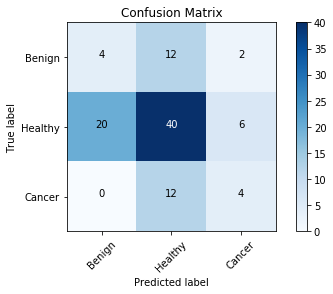

In [36]:
cm_plot_labels = ['Benign','Healthy','Cancer']
plot_confusion_matrix(conf_mat, cm_plot_labels,title ='Confusion Matrix')

**QUESTA DOVREBBE ESSERE LA FINE DELLA PRIMA PARTE DI TEST, SE FIN QUI I RISULTATI SONO BUONI, POSSIAMO FERMARCI SE NO BISOGNA FARE DATA AUGMENTATION E AUMENTARE LE EPOCHS**

In [0]:
#DATA AUGMENATION

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True)

In [0]:
image_path = "INSERT PATH TO IMAGE"

In [0]:
image = np.expand_dims(ndimage.imread(image_path),0)
plt.imshow(image[0])

In [0]:
#Generates batches of augmented images from an image

aug_iter = gen.flow(image)

In [0]:
#Get 10 samples of augmented images
aug_image = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [0]:
plots(aug_images, figsize=(20,7), rows=2)

**SE I RISULTATI OTTENUTI CON UN DETERMINATO SET DI IMPOSTAZIONI SONO BUONI E VOGLIAMO FREEZZARLI E RIPRODURLI ...**

In [0]:
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'

#Setting the seed for numpy-generated random numbers
np.random.seed(37)

#Setting the seed for Python random numbers
rn.seed(1254)

#Setting the seed for Tensorflow random numbers
tf.set_random_seed(89)

from keras import backend as K

#Force TensorFlow to use a single thread
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

#Paste training Keras code here after setting the random seeds

 **CLASS ACTIVION MAP**

In [0]:
# --- CLASS ACTIVATION MAP --- #
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from model import *
from data import *
import cv2

#After the last convolutional layer in a typical network like VGG16, we have an N-dimensional image, where N is the number of filters in this layer. 
#For example in VGG16, the last convolutional layer has 512 filters. For example, for an 1024x1024 input image (lets discard the fully connected layers, 
#so we can use any input image size we want), the output shape of the last convolutional layer will be 512x64x64. 
#Since 1024/64 = 16, we have a 16x16 spatial mapping resolution. 
#A global average pooling (GAP) layer just takes each of these 512 channels, and returns their spatial average. 
#Channels with high activations, will have high signals.

def global_average_pooling(x):
        return K.mean(x, axis = (2, 3))
  

def global_average_pooling_shape(input_shape):
        return input_shape[0:2]
  
#The second step is to assign a weight to each output from the global average pooling layer, for each of the categories. 
#This can be done by adding a dense linear layer + softmax, training an SVM on the GAP output, or applying any other linear classifier on top of the GAP. 
#These weights set the importance of each of the convolutional layer outputs.


#TO DO: 
#    --- definire una funzione che crei il modello VGG16 (ho visto che Elena ha creato il modello ma non dentro una funzione)
def get_model():
	    model = VGG16_convolutions()
	    model = load_model_weights(model, "vgg16_weights.h5")
	    
	    model.add(Lambda(global_average_pooling, 
	              output_shape=global_average_pooling_shape))
	    model.add(Dense(2, activation = 'softmax', init='uniform'))
	    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
	    model.compile(loss = 'categorical_crossentropy', \
            optimizer = sgd, metrics=['accuracy'])
	    return model

def load_model_weights(model, weights_path):
    print 'Loading model.'
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
        model.layers[k].trainable = False
    f.close()
    print 'Model loaded.'
    return model

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer    
       
#TO DO: 
# --- definire il "dataset_path"
# --- definire la funzione "load_images": è necessario creare due path diversi, uno per immagini positive e l'altro per quelle negative
#     (poi la faccio io appena riusciamo a fare i test)

def train(dataset_path):
        model = get_model()
        X, y = load_images(dataset_path)
	      print "Training.."
        checkpoint_path="weights.{epoch:02d}-{val_loss:.2f}.hdf5"
        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto')
        model.fit(X, y, nb_epoch=40, batch_size=32, validation_split=0.2, verbose=1, callbacks=[checkpoint])

#Now to create a heatmap for a class we can just take output images from the last convolutional layer, multiply them by their assigned weights 
#(different weights for each class), and sum.

def visualize_class_activation_map(model_path, img_path, output_path):
        model = load_model(model_path)
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "conv5_3")
        get_output = K.function([model.layers[0].input], \
                    [final_conv_layer.output, 
        model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        target_class = 1
        for i, w in enumerate(class_weights[:, target_class]):
                cam += w * conv_outputs[i, :, :]
        print "predictions", predictions
        cam /= np.max(cam)
        cam = cv2.resize(cam, (height, width))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        img = heatmap*0.5 + original_img
        cv2.imwrite(output_path, img)